# Rec. ITU-R S.1528

In [16]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from scipy.special import jn, jn_zeros # type: ignore
from mpl_toolkits.mplot3d import Axes3D # type: ignore
import plotly.graph_objects as go # type: ignore

## Função

In [ ]:
def ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN=-15, LF=0, tipo="geral"):
    """
    Calcula o ganho da antena de uma estação espacial de um sistema de satélite não-GEO,
    conforme a Recomendação ITU-R S.1528, tanto para feixe elíptico quanto feixe circular, 
    no FSS (Serviço Fixo por Satélite), abaixo de 30 GHz.

    # Item 1.2 - Para D/λ >= 35 - considera apenas a envoltória dos lóbulos secundários (geral: LEO, MEO, etc.)
    # Item 1.3 - Para D/λ < 35 - considera apenas a envoltória dos lóbulos secundários
               - Outros
               - LEO
               - MEO
    # Item 1.4 - Modela lóbulos secundários através de uma função analítica

    Parâmetros de entrada:
    z = razão eixo maior/eixo menor do feixe da antena (z = 1 para feixe circular)
    λ (float) = comprimento de onda da menor frequência da banda de interesse (m)
    D (float) = diâmetro da antena (m)
    ψb (float) = metade da largura de feixe de 3 dB (abaixo de Gm) no plano de interesse (graus)
    Gm (float) = ganho máximo no lóbulo principal (dBi)
    LN (int) = nível do lóbulo lateral próximo em relação ao ganho máximo (dB)
    LF (int) = nível dos lóbulos laterais distantes (dBi)
    tipo (string) = tipo de satélite (geral, MEO ou LEO)
    ψ (float ou np.ndarray): ângulo a partir do eixo da antena (graus)

    Parâmetros intermediários:
    LB = nível do lóbulo traseiro (dBi)
    Ls = ponto de interseção entre o lóbulo principal e a máscara do lóbulo lateral próximo (dB)

    Saída:    
    G (float ou np.ndarray): Ganho da antena (dBi)
    """
    if LN not in [-15, -20, -25, -30]:
        raise ValueError(
            "LN deve ser um dos seguintes valores: -15, -20, -25, -30")

    LB = max(15 + LN + 0.25 * Gm + 5 * np.log10(z), 0)
    b = 6.32
    α = 1.5

    # Tabela 1
    a_dict = {-15: 2.58 * np.sqrt(1 - 1.4 * np.log10(z)),
              -20: 2.58 * np.sqrt(1 - 1.0 * np.log10(z)),
              -25: 2.58 * np.sqrt(1 - 0.6 * np.log10(z)),
              -30: 2.58 * np.sqrt(1 - 0.4 * np.log10(z))}

    a = a_dict[LN]

    X = Gm + LN + 25 * np.log10(b * ψb)
    Y = b * ψb * 10**(0.04 * (Gm + LN - LF))

    ψ = np.abs(np.asarray(ψ))
    G = np.empty_like(ψ, dtype=float)

    if (D/λ) >= 35:  # diagrama tipo 1 (item 1.2)
        faixa_1 = (ψ > 0) & (ψ <= a * ψb) 
        faixa_2a = (ψ > a * ψb) & (ψ <= 0.5 * b * ψb)
        faixa_2b = (ψ > 0.5 * b * ψb) & (ψ <= b * ψb)
        faixa_3 = (ψ > b * ψb) & (ψ <= Y)
        faixa_4a = (ψ > Y) & (ψ <= 90)
        faixa_4b = (ψ > 90) & (ψ <= 180)
        G[faixa_1] = Gm - 3 * (ψ[faixa_1] / ψb)**α  # (1)
        G[faixa_2a] = Gm + LN + 20 * np.log10(z)  # (2a)
        G[faixa_2b] = Gm + LN  # (2b)
        G[faixa_3] = X - 25 * np.log10(ψ[faixa_3])  # (3)
        G[faixa_4a] = LF  # (4a)
        G[faixa_4b] = LB  # (4b)
        G[~(faixa_1 | faixa_2a | faixa_2b | faixa_3 | faixa_4a | faixa_4b)] = np.nan

    else:

        if tipo == "MEO":  # diagrama tipo 2 (item 1.3)
            Ls = -12
            Y = 2*ψb
            Z = Y*10**(0.04*(Gm + Ls - LF))
            faixa_1 = (ψ > 0) & (ψ <= Y)
            faixa_2 = (ψ > Y) & (ψ <= Z)
            faixa_3 = (ψ > Z) & (ψ <= 180)
            faixa_4 = (ψ > 2*ψb) & (ψ <= Z)
            G[faixa_1] = Gm - 3 * (ψ[faixa_1] / ψb)**2
            G[faixa_2] = Gm + Ls - 25 * np.log10(ψ[faixa_2]/Y)
            G[faixa_3] = LF
            G[faixa_4] = 20*np.log10(D/λ) + 3.5 - 25*np.log10(ψ[faixa_4]/ψb)

        elif tipo == "LEO":  # diagrama tipo 3 (item 1.3)
            Ls = -6.75
            Y = 1.5*ψb
            Z = Y*10**(0.04*(Gm + Ls - LF))
            faixa_1 = (ψ > 0) & (ψ <= Y)
            faixa_2a = (ψ > Y) & (ψ <= Z)
            faixa_2b = (ψ > Z) & (ψ <= 180)
            faixa_3 = (ψ > 1.5*ψb) & (ψ <= Z)
            G[faixa_1] = Gm - 3 * (ψ[faixa_1] / ψb)**2
            G[faixa_2a] = Gm + Ls - 25 * np.log10(ψ[faixa_2a]/Y)
            G[faixa_2b] = LF
            G[faixa_3] = 20*np.log10(D/λ) + 5.65 - 25*np.log10(ψ[faixa_3]/ψb)
            G[~(faixa_1 | faixa_2a | faixa_2b | faixa_3)] = np.nan

    if G.size == 1:
        return G.item()
    return G


def ganho_antena_satelite_s1528_taylor2(λ, a, Gmax, SLR, θ, nr=4):
    """
    Calcula o ganho da antena de um sistema de satélites não-GEO,
    conforme a Recomendação ITU-R S.1528, no FSS (Serviço Fixo por Satélite), 
    abaixo de 30 GHz, levando em consideração o efeito dos lóbulos laterais
    no diagrama da antena.

    Parâmetros de entrada:
    nr = n barra = número de raízes da função de Bessel

    Saída:    
    G (float ou np.ndarray): Ganho na direção do ponto considerado (dB)
    """
    
    θ = np.radians(θ)
    A = (1/np.pi) * np.arccosh(10**(SLR/20))
    μn = jn_zeros(1, nr)/np.pi  # nr raízes da função de Bessel J1(πx)
    σ = μn[-1] / np.sqrt(A**2 + (nr-1/2)**2)
    u = 2*a*np.sin(θ)/λ
    n = μn[:-1]
    v = np.zeros((u.shape) + (nr-1,))
    
    for i, ui in enumerate(n):
        v[..., i] = (1 - u**2 / (σ**2 * (A**2 + (i+1-1/2)**2))) / (1 - (u/ui)**2)

    G = Gmax + 20 * np.log10(np.abs((2 * jn(1, np.pi*u) / (np.pi*u)) * np.prod(v, axis=-1)))

    return G

## Parâmetros

In [ ]:
z = 1  
f = 6e9  # Hz
λ = 3e8 / f  # m
D = 2.4  # m
LN = -15  # dB
Gm = 37  # dBi
ψ = np.linspace(-180, 180, 5000)
ψb = np.sqrt(1200) / (D/λ)

# Calcula o ganho da antena
G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN)

In [ ]:
# Plota o diagrama de radiação da antena
plt.figure(figsize=(7, 7))
plt.plot(ψ, G - Gm, linewidth=3, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo, ψ(graus)')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(-180, 180)
plt.ylim(-40, 10)
plt.yticks(np.arange(-40, 15, 5))  
plt.grid(True)
plt.show()

In [ ]:
# Calcula o ganho da antena
G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN)

# Plota o diagrama de radiação da antena interativamente com dimensões personalizadas
fig = go.Figure()
fig.add_trace(go.Scatter(x=ψ, y=G - Gm, mode='lines', line=dict(width=3, color='blue')))
fig.update_layout(
    title='Diagrama de Radiação da Antena da Rec. ITU-R S.1528',
    xaxis_title='Ângulo fora do eixo, ψ (graus)',
    yaxis_title='Ganho relativo a Gm (dB)',
    xaxis=dict(range=[-180, 180], tickmode='linear', dtick=30),
    yaxis=dict(range=[-40, 10], tickmode='linear', dtick=5),
    template='plotly_white',
    width=800,  # Largura da figura
    height=600   # Altura da figura
)
fig.show()

In [ ]:
ψ_radians = np.radians(ψ)
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(ψ_radians, G - Gm, linewidth=3, color='b')
ax.set_title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528', va='bottom')
ax.set_theta_offset(-np.pi/2)  # Rotate the plot 90 degrees
ax.set_theta_direction(-1)  # Set the direction of the angle
ax.set_ylim(-40, 10)  # Set the radial limits
ax.set_yticks(np.arange(-40, 15, 5))  # Set the radial ticks at intervals of 5 dB
plt.show()

In [ ]:
# Calcula o ganho da antena
G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN)

# Convert to radians for polar plot
ψ_radians = np.radians(ψ)

# Create interactive plot
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=G - Gm,
    theta=ψ,
    mode='lines',
    line=dict(width=3, color='blue')
))

fig.update_layout(
    title='Diagrama de Radiação da Antena da Rec. ITU-R S.1528',
    polar=dict(
        radialaxis=dict(range=[-40, 10], tickvals=np.arange(-40, 15, 5))
    ),
    showlegend=False,
    width=600,  # Largura da figura
    height=600   # Altura da figura
)

fig.show()

In [ ]:
plt.figure(figsize=(7, 7))

LN_valores = [-15, -20, -25, -30]
cores = ['b', 'g', 'r', 'k']
for LN, color in zip(LN_valores, cores):
    G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN)
    plt.plot(ψ/ψb, G - Gm, linewidth=2, color=color, label=f'LN = {LN} dB')

plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo relativo, ψ/ψ3dB (graus)')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(0, 30)
plt.ylim(-40, 10)
plt.yticks(np.arange(-40, 15, 5)) 
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

## Item 1.2 - Geral

In [ ]:
def ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN=-15, LF=0, tipo="geral"):
    """
    Calcula o ganho da antena de uma estação espacial de um sistema de satélite não-GEO,
    conforme a Recomendação ITU-R S.1528, tanto para feixe elíptico quanto feixe circular, 
    no FSS (Serviço Fixo por Satélite), abaixo de 30 GHz.

    # Item 1.2 - Para D/λ >= 35 - considera apenas a envoltória dos lóbulos secundários (geral: LEO, MEO, etc.)
    # Item 1.3 - Para D/λ < 35 - considera apenas a envoltória dos lóbulos secundários
               - Outros
               - LEO
               - MEO
    # Item 1.4 - Modela lóbulos secundários através de uma função analítica

    Parâmetros de entrada:
    z = razão eixo maior/eixo menor do feixe da antena (z = 1 para feixe circular)
    λ (float) = comprimento de onda da menor frequência da banda de interesse (m)
    D (float) = diâmetro da antena (m)
    ψb (float) = metade da largura de feixe de 3 dB (abaixo de Gm) no plano de interesse (graus)
    Gm (float) = ganho máximo no lóbulo principal (dBi)
    LN (int) = nível do lóbulo lateral próximo em relação ao ganho máximo (dB)
    LF (int) = nível dos lóbulos laterais distantes (dBi)
    tipo (string) = tipo de satélite (geral, MEO ou LEO)
    ψ (float ou np.ndarray): ângulo a partir do eixo da antena (graus)

    Parâmetros intermediários:
    LB = nível do lóbulo traseiro (dBi)
    Ls = ponto de interseção entre o lóbulo principal e a máscara do lóbulo lateral próximo (dB)

    Saída:    
    G (float ou np.ndarray): Ganho da antena (dBi)
    """
    if LN not in [-15, -20, -25, -30]:
        raise ValueError("LN deve ser um dos seguintes valores: -15, -20, -25, -30")

    LB = max(15 + LN + 0.25 * Gm + 5 * np.log10(z), 0)
    b = 6.32
    α = 1.5

    a_dict = {
        -15: 2.58 * np.sqrt(1 - 1.4 * np.log10(z)),
        -20: 2.58 * np.sqrt(1 - 1.0 * np.log10(z)),
        -25: 2.58 * np.sqrt(1 - 0.6 * np.log10(z)),
        -30: 2.58 * np.sqrt(1 - 0.4 * np.log10(z)),
    }
    a = a_dict[LN]

    X = Gm + LN + 25 * np.log10(b * ψb)
    Y = b * ψb * 10**(0.04 * (Gm + LN - LF))

    ψ = np.abs(np.asarray(ψ))
    G = np.full_like(ψ, np.nan, dtype=float)

    # diagrama tipo 1 (item 1.2)
    G = np.where((ψ > 0) & (ψ <= a * ψb), Gm - 3 * (ψ / ψb)**α, G)
    G = np.where((ψ > a * ψb) & (ψ <= 0.5 * b * ψb), Gm + LN + 20 * np.log10(z), G)
    G = np.where((ψ > 0.5 * b * ψb) & (ψ <= b * ψb), Gm + LN, G)
    G = np.where((ψ > b * ψb) & (ψ <= Y), X - 25 * np.log10(ψ), G)
    G = np.where((ψ > Y) & (ψ <= 90), LF, G)
    G = np.where((ψ > 90) & (ψ <= 180), LB, G)
    
    if (D/λ) < 35:  
        if tipo == "MEO":  # diagrama tipo 2 (item 1.3)
            Ls = -12
            Y = 2*ψb
            Z = Y*10**(0.04*(Gm + Ls - LF))
            G = np.where((ψ > 0) & (ψ <= Y), Gm - 3 * (ψ / ψb)**2, G)
            G = np.where((ψ > Y) & (ψ <= Z), Gm + Ls - 25 * np.log10(ψ/Y), G)
            G = np.where((ψ > Z) & (ψ <= 180), LF, G)
            G = np.where((ψ > 2*ψb) & (ψ <= Z), 20*np.log10(D/λ) + 3.5 - 25*np.log10(ψ/ψb), G)

        elif tipo == "LEO":  # diagrama tipo 3 (item 1.3)
            Ls = -6.75
            Y = 1.5*ψb
            Z = Y*10**(0.04*(Gm + Ls - LF))
            G = np.where((ψ > 0) & (ψ <= Y), Gm - 3 * (ψ / ψb)**2, G)
            G = np.where((ψ > Y) & (ψ <= Z), Gm + Ls - 25 * np.log10(ψ/Y), G)
            G = np.where((ψ > Z) & (ψ <= 180), LF, G)
            G = np.where((ψ > 1.5*ψb) & (ψ <= Z), 20*np.log10(D/λ) + 5.65 - 25*np.log10(ψ/ψb), G)

    if G.size == 1:
        return G.item()
    return G

In [ ]:
# Parâmetros
z = 1  
f = 6e9  # Hz
λ = 3e8 / f  # m
D = 2.4  # m
Gm = 37  # dBi
ψ = np.linspace(-180, 180, 5000)
ψb = np.sqrt(1200) / (D/λ)
LN_valores = [-15, -20, -25, -30]
cores = ['b', 'g', 'r', 'k']

plt.figure(figsize=(7, 7))

for LN, color in zip(LN_valores, cores):
    G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN)
    plt.plot(ψ / ψb, G - Gm, linewidth=2, color=color)
    y_pos = (G - Gm)[np.searchsorted(ψ / ψb, 5)] + 1 
    plt.text(4, y_pos, f'LN = {LN} dB', color=color, verticalalignment='bottom')

plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo relativo, ψ/ψ3dB (graus)')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(0, 30)
plt.ylim(-40, 10)
plt.yticks(np.arange(-40, 15, 5)) 
plt.grid(True)
plt.show()

## Item 1.3 - MEO e LEO

### MEO

In [ ]:
# Parâmetros gerais
z = 1
f = 18.8e9  # Hz
λ = 3e8 / f  # m
D = 0.36  # m
ψb = 1.6  # graus
Gm = 35  # dBi

# Parâmetros MEO
LF = 3  # dB

# Calcula o ganho da antena
ψ = np.linspace(-180, 180, 5000)
G_MEO = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, -15, LF, tipo="MEO")

# Plota o diagrama de radiação da antena
plt.figure(figsize=(7, 7))
plt.plot(ψ, G_MEO - Gm, linewidth=3, color='b')
plt.title('Diagrama de Radiação da Antena MEO da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo, ψ(graus)')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(-180, 180)
plt.ylim(-40, 10)
plt.yticks(np.arange(-40, 15, 5))  
plt.grid(True)
plt.show()

In [ ]:
ψ_radians = np.radians(ψ)
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(ψ_radians, G_MEO - Gm, linewidth=3, color='b')
ax.set_title('Diagrama de Radiação da Antena MEO da Rec. ITU-R S.1528', va='bottom')
ax.set_theta_offset(-np.pi/2)  # Rotate the plot 90 degrees
ax.set_theta_direction(-1)  # Set the direction of the angle
ax.set_ylim(-40, 10)  # Set the radial limits
ax.set_yticks(np.arange(-40, 15, 5))  # Set the radial ticks at intervals of 5 dB
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(ψ/ψb, G_MEO - Gm, linewidth=3, color='b', linestyle=':')
plt.title('Diagrama de Radiação da Antena MEO da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo relativo, ψ/ψ3dB')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(0, 18)
plt.ylim(-40, 0)
plt.yticks(np.arange(-40, 0, 5))  
plt.grid(True)
plt.show()

### LEO

In [ ]:
# Parâmetros gerais
z = 1
f = 18.8e9  # Hz
λ = 3e8 / f  # m
D = 0.36  # m
ψb = 1.6  # graus
Gm = 35  # dBi

# Parâmetros MEO
LF = 5  # dB

# Calcula o ganho da antena
ψ = np.linspace(-180, 180, 5000)
G_LEO = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, -15, LF, tipo="LEO")

# Plota o diagrama de radiação da antena
plt.figure(figsize=(7, 7))
plt.plot(ψ, G_MEO - Gm, linewidth=3, color='b')
plt.title('Diagrama de Radiação da Antena LEO da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo, ψ(graus)')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(-180, 180)
plt.ylim(-40, 10)
plt.yticks(np.arange(-40, 15, 5))  
plt.grid(True)
plt.show()

In [ ]:
ψ_radians = np.radians(ψ)
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(ψ_radians, G_LEO - Gm, linewidth=3, color='b')
ax.set_title('Diagrama de Radiação da Antena MEO da Rec. ITU-R S.1528', va='bottom')
ax.set_theta_offset(-np.pi/2)  # Rotate the plot 90 degrees
ax.set_theta_direction(-1)  # Set the direction of the angle
ax.set_ylim(-40, 10)  # Set the radial limits
ax.set_yticks(np.arange(-40, 15, 5))  # Set the radial ticks at intervals of 5 dB
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(ψ/ψb, G_LEO - Gm, linewidth=3, color='r', linestyle='--')
plt.title('Diagrama de Radiação da Antena LEO da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo relativo, ψ/ψ3dB')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(0, 18)
plt.ylim(-40, 0)
plt.yticks(np.arange(-40, 0, 5))  
plt.grid(True)
plt.show()

### MEO e LEO

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(ψ/ψb, G_MEO - Gm, linewidth=3, color='b', linestyle=':', label='MEO')
plt.plot(ψ/ψb, G_LEO - Gm, linewidth=3, color='r', linestyle='--', label='LEO')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528')
plt.xlabel('Ângulo fora do eixo relativo, ψ/ψ3dB')
plt.ylabel('Ganho relativo a Gm (dB)')
plt.xlim(0, 18)
plt.ylim(-40, 0)
plt.yticks(np.arange(-40, 0, 5))  
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Calcular as três primeiras raízes da função de Bessel de primeira espécie de índice 1
j1_roots = jn_zeros(1, 3)

print("Três primeiras raízes da função de Bessel J1(x):")
print(j1_roots)

print("Três primeiras raízes da função de Bessel J1(πx):")
print(j1_roots/np.pi)

xmax = 18
xmin = -1
x = np.linspace(xmin, xmax, 500)
fig, ax = plt.subplots()
ax.plot(x, jn(1, x), label=r'função $J_1(x)$', linewidth=2)
ax.scatter(j1_roots, np.zeros((3, )), s=30, c='r',
           label=r"Zeros de $J_1(x)$", zorder=5)
ax.scatter(0, 0, s=30, c='k',
           label=r"Raíz em 0", zorder=5)
ax.hlines(0, 0, xmax, color='k')
ax.set_xlim(xmin, xmax)
plt.xlabel('$x$')
plt.ylabel('$J_1(x)$')
plt.legend()
#plt.grid(True)
plt.show()

## Item 1.4 - Taylor

In [68]:
def ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, θ, φ, l=4):
    """
    Calcula o ganho de uma antena em um sistema de satélites não-GEO,
    conforme a Recomendação ITU-R S.1528, no FSS (Serviço Fixo por Satélite) 
    abaixo de 30 GHz, levando em consideração o efeito dos lóbulos laterais 
    no diagrama da antena.

    Referência:
    Taylor, T. “Design of Circular Aperture for Narrow Beamwidth and Low Sidelobes.” 
    IRE Trans. on Antennas and Propagation, Vol. 5, No. 1, January 1960, pp. 17-22.

    Parâmetros de entrada:
    λ (float): Comprimento de onda da menor frequência da banda de interesse (em metros).
    Gmax (float): Ganho máximo do diagrama da antena (em dB).
    SLR (int): Razão de lóbulos laterais do diagrama da antena (em dB).
    Lr, Lt (float): Tamanhos radial e transversal da área de radiação efetiva da antena do satélite (em metros).
    l (int): Número de lóbulos secundários considerados no diagrama (coincidem com as raízes da função de Bessel).
    θ (float ou np.ndarray): Ângulo entre a direção do centro da Terra (ponto subsatélite) e o ponto de teste (em graus).
    φ (float ou np.ndarray): Ângulo entre o plano meridiano do satélite (plano xz) e o plano definido pela direção do centro da Terra e o ponto de teste (em graus).

    Saída:
    G (float ou np.ndarray): Ganho na direção do ponto considerado (em dB).
    """
    
    # Converte os ângulos de graus para radianos e toma o valor absoluto
    φ = np.abs(np.radians(φ))
    θ = np.abs(np.radians(θ))

    # Verificação básica dos parâmetros de entrada
    if λ <= 0:
        raise ValueError("O comprimento de onda λ deve ser positivo.")
    if not (isinstance(l, int) and l > 0):
        raise ValueError("O parâmetro l deve ser um inteiro positivo.")

    # Cálculos intermediários
    A = (1/np.pi) * np.arccosh(10**(SLR/20))
    raizes_J1 = jn_zeros(1, l) / np.pi  # l raízes da função de Bessel J1(πx)
    σ = raizes_J1[-1] / np.sqrt(A**2 + (l-1/2)**2)
    u = (np.pi/λ) * np.sqrt((Lr*np.sin(θ)*np.cos(φ))**2 + (Lt*np.sin(θ)*np.sin(φ))**2)

    # Calculando v para o ganho
    μ = jn_zeros(1, l-1) / np.pi
    v = np.ones(u.shape + (l-1,))
    
    for i, ui in enumerate(μ):
        v[..., i] = (1 - u**2 / (np.pi**2 * σ**2 * (A**2 + (i+1 - 0.5)**2))) / (1 - (u/(np.pi*ui))**2)

    # Evitar divisões por zero
    with np.errstate(divide='ignore', invalid='ignore'):
        G = Gmax + 20 * np.log10(np.abs((2 * jn(1, u) / u) * np.prod(v, axis=-1)))

    # Substitui valores indefinidos por -inf (ou outro valor desejado)
    G = np.nan_to_num(G, nan=-np.inf)

    return G

SLR = 20 dB
A = 0.95277
σ = 1.1692
Roll-off = 7 dB
a = 13.4 graus
b = 13.4 graus
Lr = 0.08 metros
Lt = 0.08 metros


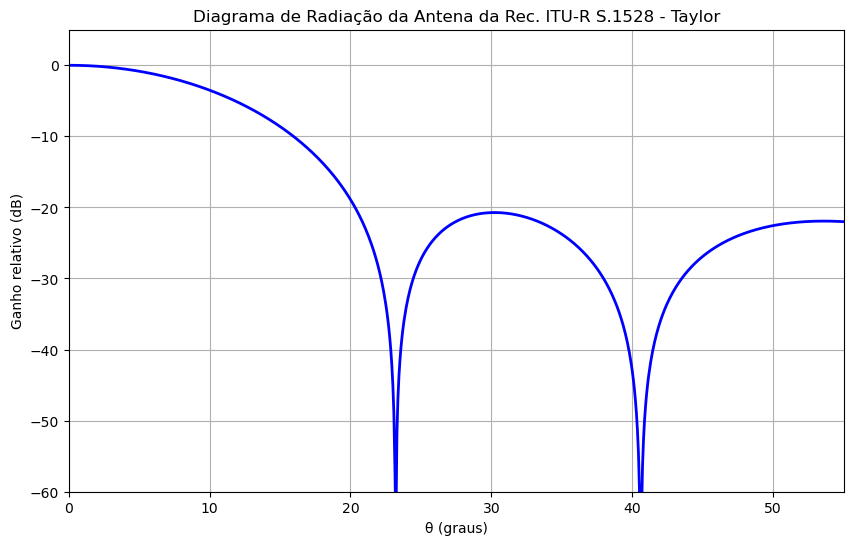

In [71]:
# Exemplo (página 8 da Rec. ITU-R S.1528)

f = 12e9  # 12 GHz
λ = 3e8/f  # metros
SLR = 20  # dB
l = 4  # número de lóbulos secundários
Gmax = 30
altitude = 1469 # km
raio_celula = 350 # km
roll_off = 7  # dB

# Tabela 2, pág. 9, da Rec. ITU-R S.1528, para roll-off = 7 dB
a = np.degrees(np.arctan(raio_celula/altitude))
b = np.degrees(np.arctan(raio_celula/altitude))
Lr = λ*0.74/np.sin(np.radians(a))
Lt = λ*0.74/np.sin(np.radians(b))

A = (1/np.pi) * np.arccosh(10**(SLR/20))
raizes_J1 = jn_zeros(1, l)/np.pi  # l raízes da função de Bessel J1(πx)
σ = raizes_J1[-1] / np.sqrt(A**2 + (l-1/2)**2)

print(f"SLR = {20} dB")
print(f"A = {A:.5}")
print(f"σ = {σ:.5}")
print(f'Roll-off = {roll_off} dB')
print(f'a = {a:.1f} graus')
print(f'b = {b:.1f} graus')
print(f'Lr = {Lr:.2f} metros')
print(f'Lt = {Lt:.2f} metros')

θ = np.linspace(-180, 180, 5000)
plt.figure(figsize=(10, 6))
G = ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, θ, 0)
plt.plot(θ, G-Gmax, linewidth=2, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(0, 55)
plt.ylim(-60, 5)
plt.grid(True)
plt.show()

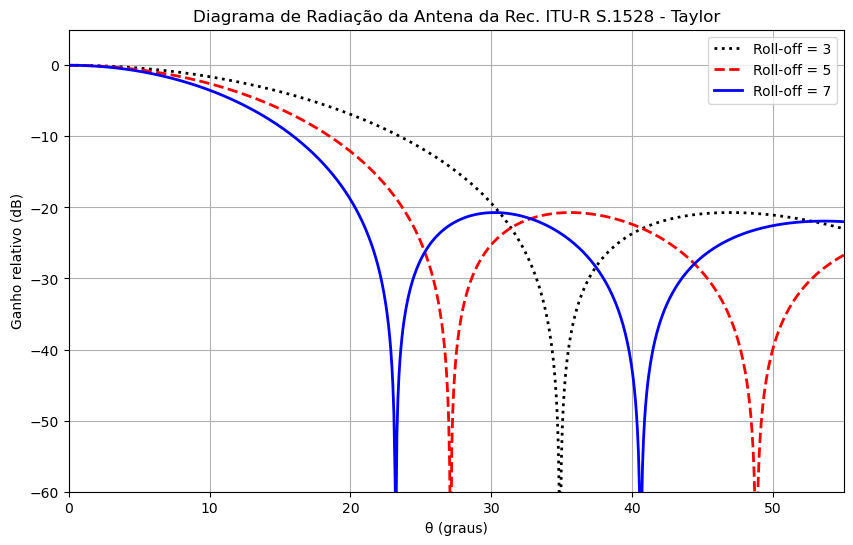

In [72]:
roll_off = 3  # dB
Lr = λ*0.51/np.sin(np.radians(a))
Lt = λ*0.51/np.sin(np.radians(b))
G = ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, θ, 0)
plt.figure(figsize=(10, 6))
plt.plot(θ, G-Gmax, linewidth=2, label='Roll-off = 3', color='k', linestyle=':')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(0, 55)
plt.ylim(-60, 5)
plt.grid(True)

roll_off = 5  # dB
Lr = λ*0.64/np.sin(np.radians(a))
Lt = λ*0.64/np.sin(np.radians(b))
G = ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, θ, 0)
plt.plot(θ, G-Gmax, linewidth=2, label='Roll-off = 5', color='r', linestyle='--')

roll_off = 7  # dB
Lr = λ*0.74/np.sin(np.radians(a))
Lt = λ*0.74/np.sin(np.radians(b))
G = ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, θ, 0)
plt.plot(θ, G-Gmax, linewidth=2, label='Roll-off = 7', color='b', linestyle='-')
plt.legend()
plt.show()

In [ ]:
# def ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, l, θ, φ):
#     """
#     Calcula o ganho da antena de um sistema de satélites não-GEO,
#     conforme a Recomendação ITU-R S.1528, no FSS (Serviço Fixo por Satélite), 
#     abaixo de 30 GHz, levando em consideração o efeito dos lóbulos laterais
#     no diagrama da antena.
    
#     Parâmetros de entrada:
#     λ (float) = comprimento de onda da menor frequência da banda de interesse (m)
#     Gmax (float) = ganho máximo do diagrama (dB)
#     SLR (int) = razão de lóbulos laterais do diagrama (dB)
#     Lr e Lt (float) = tamanhos radial e transverso da área de radiação efetiva da antena do satélite (m)
#     l (int) = número de lóbulos secundários considerado no diagrama
#     θ (float ou np.ndarray) = ângulo a partir do eixo da antena (graus)
#     φ (float ou np.ndarray) = ângulo em torno do eixo da antena (graus)
    
#     Saída:
#     G (float ou np.ndarray): Ganho na direção do ponto considerado (dB)
#     """
#     # Converter os ângulos de graus para radianos
#     φ = np.radians(φ)
#     θ = np.abs(np.radians(θ))

#     # Inicializar G com zeros, do mesmo tamanho de θ
#     G = np.zeros_like(θ)

#     # Faixa de θ de 0 a 90 graus
#     faixa_1 = (θ >= 0) & (θ <= np.pi/2)

#     # Cálculos intermediários
#     A = (1/np.pi) * np.arccosh(10**(SLR/20))
#     raizes_J1 = jn_zeros(1, l) / np.pi  # l raízes da função de Bessel J1(πx)
#     σ = raizes_J1[-1] / np.sqrt(A**2 + (l-1/2)**2)

#     # Calcular u para a faixa 1
#     u = (np.pi/λ) * np.sqrt((Lr*np.sin(θ)*np.cos(φ))**2 + (Lt*np.sin(θ)*np.sin(φ))**2)

#     # Calcular v e o ganho para faixa 1
#     μ = jn_zeros(1, 3) / np.pi
#     v = np.ones((u.size, 3))  # Inicializa v com o tamanho correto
    
#     for i in range(3):
#         v[:, i] = (1 - u**2 / (np.pi**2 * σ**2 * (A**2 + (i+1-1/2)**2))) / (1 - (u/(np.pi*μ[i]))**2)

#     G[faixa_1] = Gmax + 20 * np.log10(np.abs((2 * jn(1, u[faixa_1]) / u[faixa_1]) * np.prod(v[faixa_1], axis=-1)))

#     return G

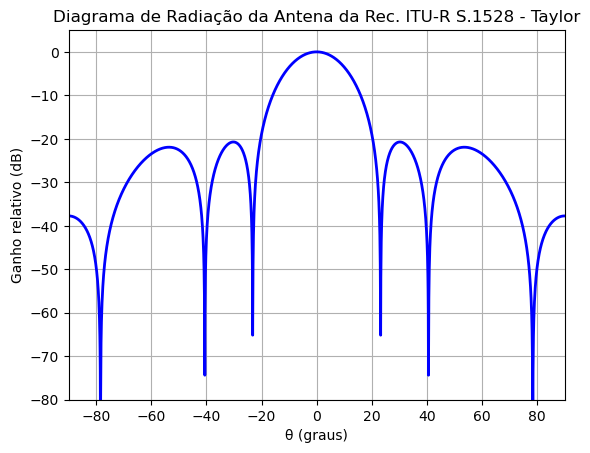

In [74]:
plt.plot(θ, G-Gmax, linewidth=2, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(-90, 90)
plt.ylim(-80, 5)
plt.grid(True)
plt.show()

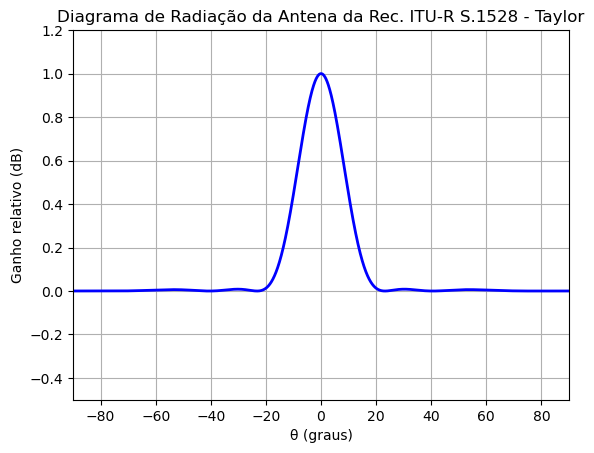

In [54]:
plt.plot(θ, 10**((G-Gmax)/10), linewidth=2, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(-90, 90)
plt.ylim(-0.5, 1.2)
plt.grid(True)
plt.show()

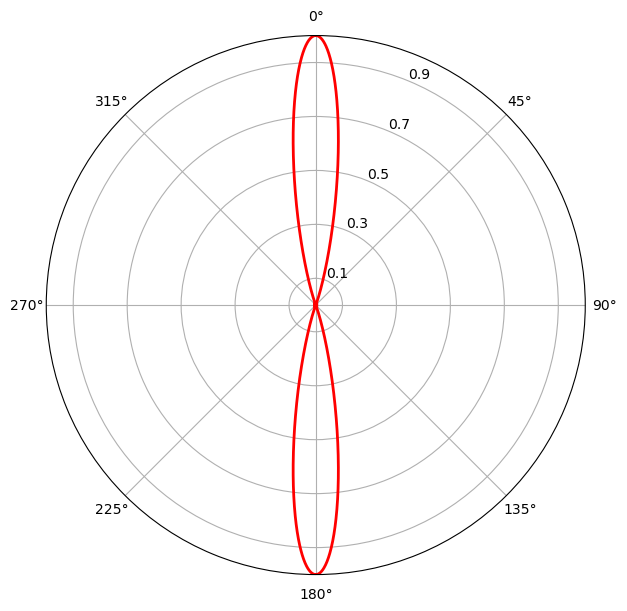

In [55]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})
ax.plot(θ*np.pi/180, 10**((G-Gmax)/10), linewidth=2, color='r')
ax.set_theta_zero_location('N')  # Zero at the top (North)
ax.set_theta_direction(-1)       # Clockwise direction
ax.set_ylim(0.001, 1)  # Set the radial limits
ax.set_yticks(np.arange(0.1, 1, 0.2))
ax.grid(True)
plt.show()

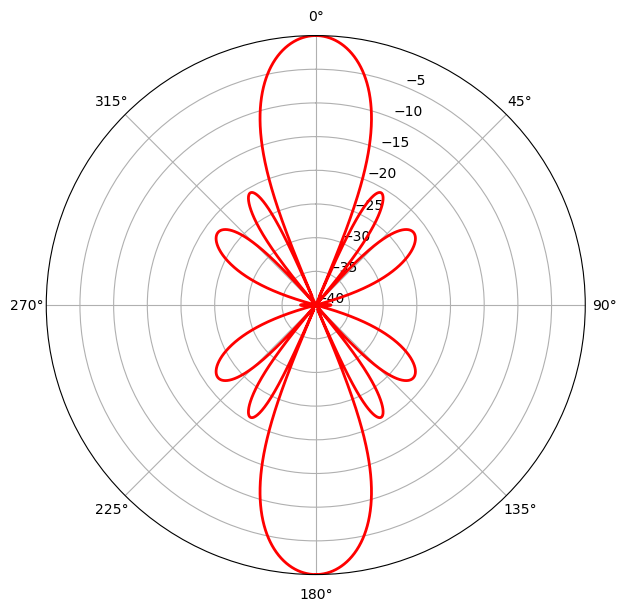

In [56]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})
ax.plot(θ*np.pi/180, G-Gmax, linewidth=2, color='r')
ax.set_theta_zero_location('N')  # Zero at the top (North)
ax.set_theta_direction(-1)       # Clockwise direction
ax.set_ylim(-40, 0)  # Set the radial limits
ax.set_yticks(np.arange(-40, 0, 5))  # Set the radial ticks at intervals of 5 dB
ax.grid(True)
plt.show()

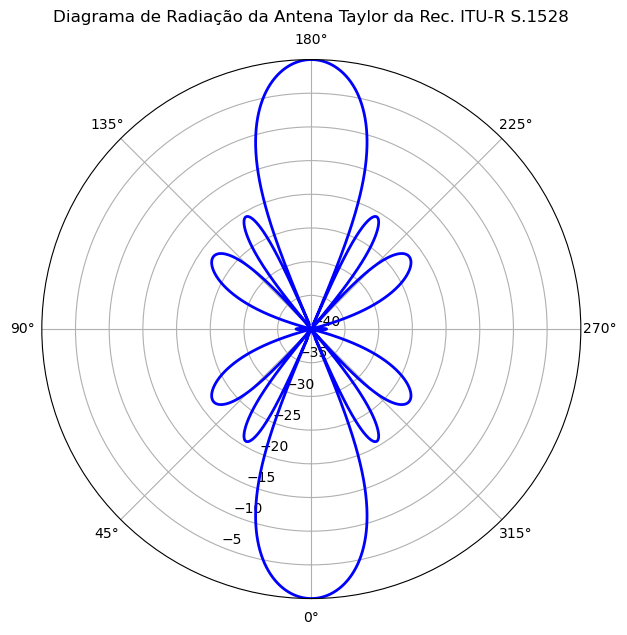

In [57]:
θ = np.linspace(-180, 180, 5000)
θ_radians = np.radians(θ)
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(θ_radians, G-Gmax, linewidth=2, color='b')
ax.set_title('Diagrama de Radiação da Antena Taylor da Rec. ITU-R S.1528', va='bottom')
ax.set_theta_offset(-np.pi/2)  # Rotate the plot 90 degrees
ax.set_theta_direction(-1)  # Set the direction of the angle
ax.set_ylim(-40, 0)  # Set the radial limits
ax.set_yticks(np.arange(-40, 0, 5))  # Set the radial ticks at intervals of 5 dB
plt.show()

In [58]:
f = 5e9  # Hz
λ = 3e8 / f  # m
SLR = 20
roll_off = 5
a = λ*roll_off/2
Gmax = 30

θ = np.linspace(-180, 180, 5000)
plt.figure(figsize=(10, 6))
G = ganho_antena_satelite_s1528_taylor2(λ, a, Gmax, SLR, θ)
plt.plot(θ, G - Gmax, linewidth=2, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(0, 60)
plt.ylim(-60, 0)
plt.grid(True)
plt.show()

NameError: name 'ganho_antena_satelite_s1528_taylor2' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
θ = np.linspace(-180, 180, 5000)
plt.figure(figsize=(10, 6))
G = ganho_antena_satelite_s1528_taylor2(λ, a, Gmax, SLR, θ)
plt.plot(θ, G - Gmax, linewidth=2, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(-91, 90)
plt.ylim(-60, 5)
plt.grid(True)
plt.show()

In [ ]:
θ = np.linspace(-180, 180, 5000)
θ_radians = np.radians(θ)
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(θ_radians, G-Gmax, linewidth=3, color='b')
ax.set_title('Diagrama de Radiação da Antena Taylor da Rec. ITU-R S.1528', va='bottom')
ax.set_theta_offset(-np.pi/2)  # Rotate the plot 90 degrees
ax.set_theta_direction(-1)  # Set the direction of the angle
ax.set_ylim(-40, 0)  # Set the radial limits
ax.set_yticks(np.arange(-40, 0, 5))  # Set the radial ticks at intervals of 5 dB
plt.show()

## Outros gráficos

In [ ]:
# Definir os parâmetros
f = 5e9  # Hz
λ = 3e8 / f  # m
SLR = 20
l = 4
roll_off = 5
Lr = λ*roll_off
Lt = λ*roll_off
Gmax = 30

ψ = np.linspace(0, 180, 360)  # Ângulos de 0 a 180 graus
φ = np.linspace(0, 360, 360)  # Ângulos de 0 a 360 graus
ψ, φ = np.meshgrid(ψ, φ)

# Calcular o ganho para cada combinação de ψ e φ
G = ganho_antena_satelite_s1528_taylor(λ, Gmax, SLR, Lr, Lt, l, ψ, φ)

# Converter os ângulos para radianos para o gráfico 3D
ψ_rad = np.radians(ψ)
φ_rad = np.radians(φ)

# Converter coordenadas esféricas para cartesianas
X = G * np.sin(ψ_rad) * np.cos(φ_rad)
Y = G * np.sin(ψ_rad) * np.sin(φ_rad)
Z = G * np.cos(ψ_rad)

# Criar o gráfico 3D interativo
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# Configurações do gráfico
fig.update_layout(title='Diagrama de Radiação da Antena',
                  scene=dict(xaxis_title='X',
                             yaxis_title='Y',
                             zaxis_title='Ganho (dBi)'),
                  autosize=False,
                  width=800, height=800)

fig.show()

In [ ]:
f = 5e9  # Hz
λ = 3e8 / f  # m
SLR = 20
roll_off = 5
a = λ*roll_off/2
Gmax = 30

θ = np.linspace(-180, 180, 5000)
plt.figure(figsize=(10, 6))
G = ganho_antena_satelite_s1528_taylor2(λ, a, Gmax, SLR, θ)
plt.plot(θ, G - Gmax, linewidth=2, color='b')
plt.title('Diagrama de Radiação da Antena da Rec. ITU-R S.1528 - Taylor')
plt.xlabel('θ (graus)')
plt.ylabel('Ganho relativo (dB)')
plt.xlim(0, 60)
plt.ylim(-60, 0)
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as Axes3D
from numpy import sin,cos,pi, exp,log
from tqdm import tqdm
# import mpl_toolkits.mplot3d.axes3d as Axes3D
from matplotlib import cm, colors



phi1d = vals_phi
phi = np.array(phi1d)/180*pi;

power1d = vals_r
power = np.array(power1d);
# power = power-min(power)
power = 10**(power/10) # I used linscale

X = power*sin(phi)*sin(theta)
Y = power*cos(phi)*sin(theta)
Z = power*cos(theta)

X = X.reshape([360,181])
Y = Y.reshape([360,181])
Z = Z.reshape([360,181])

def interp_array(N1):  # add interpolated rows and columns to array
    N2 = np.empty([int(N1.shape[0]), int(2*N1.shape[1] - 1)])  # insert interpolated columns
    N2[:, 0] = N1[:, 0]  # original column
    for k in range(N1.shape[1] - 1):  # loop through columns
        N2[:, 2*k+1] = np.mean(N1[:, [k, k + 1]], axis=1)  # interpolated column
        N2[:, 2*k+2] = N1[:, k+1]  # original column
    N3 = np.empty([int(2*N2.shape[0]-1), int(N2.shape[1])])  # insert interpolated columns
    N3[0] = N2[0]  # original row
    for k in range(N2.shape[0] - 1):  # loop through rows
        N3[2*k+1] = np.mean(N2[[k, k + 1]], axis=0)  # interpolated row
        N3[2*k+2] = N2[k+1]  # original row
    return N3

interp_factor=1

for counter in range(interp_factor):  # Interpolate between points to increase number of faces
    X = interp_array(X)
    Y = interp_array(Y)
    Z = interp_array(Z)

N = np.sqrt(X**2 + Y**2 + Z**2)
Rmax = np.max(N)
N = N/Rmax

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1, projection='3d')
axes_length = 0.65
ax.plot([0, axes_length*Rmax], [0, 0], [0, 0], linewidth=2, color='red')
ax.plot([0, 0], [0, axes_length*Rmax], [0, 0], linewidth=2, color='green')
ax.plot([0, 0], [0, 0], [0, axes_length*Rmax], linewidth=2, color='blue')

# Find middle points between values for face colours
N = interp_array(N)[1::2,1::2]

mycol = cm.jet(N)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=mycol, linewidth=0.5, antialiased=True, shade=False)  # , alpha=0.5, zorder = 0.5)

ax.set_xlim([-axes_length*Rmax, axes_length*Rmax])
ax.set_ylim([-axes_length*Rmax, axes_length*Rmax])
ax.set_zlim([-axes_length*Rmax, axes_length*Rmax])

m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(power)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.colorbar(m, shrink=0.8)
ax.view_init(azim=300, elev=30)

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
r = np.linspace(0, 1.25, 50)
p = np.linspace(0, 2*np.pi, 50)
R, P = np.meshgrid(r, p)
Z = ((R**2 - 1)**2)

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(0, 1)
ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi)$')

plt.show()

In [ ]:
# Parâmetros
z = 1  
f = 6e9  # Hz
λ = 3e8 / f  # m
D = 2.4  # m
LN = -15  # dB
Gm = 37  # dBi
ψb = np.sqrt(1200) / (D/λ)

ψ = np.linspace(0, 180, 360)  # Ângulos de 0 a 180 graus
φ = np.linspace(0, 360, 360)  # Ângulos de 0 a 360 graus
ψ, φ = np.meshgrid(ψ, φ)

# Calcular o ganho para cada combinação de ψ e φ
G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ)

# Converter os ângulos para radianos para o gráfico 3D
ψ_rad = np.radians(ψ)
φ_rad = np.radians(φ)

# Converter coordenadas esféricas para cartesianas
X = G * np.sin(ψ_rad) * np.cos(φ_rad)
Y = G * np.sin(ψ_rad) * np.sin(φ_rad)
Z = G * np.cos(ψ_rad)

# Criar o gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Adicionar uma barra de cores
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Configurações do gráfico
ax.set_title('Diagrama de Radiação da Antena')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Ganho (dBi)')

plt.show()

In [ ]:
# Definir os parâmetros
z = 1  
f = 6e9  # Hz
λ = 3e8 / f  # m
D = 2.4  # m
LN = -15  # dB
Gm = 37  # dBi
ψb = np.sqrt(1200) / (D/λ)
ψ = np.linspace(0, 180, 360)  # Ângulos de 0 a 180 graus
φ = np.linspace(0, 360, 360)  # Ângulos de 0 a 360 graus
ψ, φ = np.meshgrid(ψ, φ)

# Calcular o ganho para cada combinação de ψ e φ
G = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ)

# Converter os ângulos para radianos para o gráfico 3D
ψ_rad = np.radians(ψ)
φ_rad = np.radians(φ)

# Converter coordenadas esféricas para cartesianas
X = G * np.sin(ψ_rad) * np.cos(φ_rad)
Y = G * np.sin(ψ_rad) * np.sin(φ_rad)
Z = G * np.cos(ψ_rad)

# Criar o gráfico 3D interativo
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# Configurações do gráfico
fig.update_layout(title='Diagrama de Radiação da Antena',
                  scene=dict(xaxis_title='X',
                             yaxis_title='Y',
                             zaxis_title='Ganho (dBi)'),
                  autosize=False,
                  width=800, height=800)

fig.show()

## Comparação dos diagramas

In [ ]:
# Especificações
z = 1  
f = 1990e6  # Hz
λ = 3e8 / f  # m
LN = -15  # dB
LF = 0  # dB
Gm = 38  # dBi
ψ = np.linspace(-90, 90, 2000)

D = 6 # m
ψb = np.sqrt(1200) / (D/λ)
G12 = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN, LF, tipo="geral")

D = 5.2  # m
ψb = np.sqrt(1200) / (D/λ)
G13 = ganho_antena_satelite_s1528(z, λ, D, ψb, Gm, ψ, LN, LF, tipo="LEO")

SLR = 15
Lr = 5.3
Lt = 5.3
l = 4
φ = 0
θ = np.linspace(-90, 90, 2000)
G14 = ganho_antena_satelite_s1528_taylor(λ, Gm, SLR, Lr, Lt, l, θ, φ)

plt.figure(figsize=(10, 6))
plt.plot(ψ, G12, label='S1528 - item 1.2 - Geral', linewidth=2, color='red')
plt.plot(ψ, G13, label='S1528 - item 1.3 - LEO', linewidth=2, color='green')
plt.plot(θ, G14, label='S1528 - item 1.4 - Taylor', linewidth=2, color='blue')
plt.xlim(-70, 71)
plt.ylim(-5, 40)

plt.yticks(np.arange(-5, 41, 5))    
plt.title(r'Diagramas de Radiação das Antenas da Rec. ITU-R S.1528', fontsize=14)
plt.xlabel(r'Ângulo fora do eixo (graus)', fontsize=12)
plt.ylabel(r'Ganho (dBi)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()